In [4]:
import pandas as pd 
import pickle
from hpo import all_archs
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

dnames = ['cora', 'citeseer', 'pubmed', 'cs', 'physics', 'photo', 'computers', 'arxiv', 'proteins']
dnames_o = ['cora', 'citeseer', 'pubmed', 'cs', 'physics', 'photo', 'computers', 'arxiv']
archs = all_archs()
hashs = [i.hash_arch() for i in archs]
link_list = [
[0,1,2,3],
[0,1,2,2],
[0,1,1,2],
[0,0,1,3],
[0,1,1,1],
[0,0,1,1],
[0,0,0,1],
[0,0,1,2],
[0,0,0,0],
]


def read_bench(dname):
    f = open("light/{}.bench".format(dname), "rb")
    bench = pickle.load(f)
    f.close()
    return bench

def get_perf_rank(bench):
    li = []
    for h in hashs:
        if h in bench:
            li.append((h, bench[h]['perf']))
    li.sort(key = lambda x:x[1], reverse=True) 
    top_arch = set(map(lambda x:x[0], li[:len(bench) // 20]))
    sorted_hashs = list(map(lambda x:x[0], li))

    h2r = {}
    for i, tup in enumerate(li):
        h2r[tup[0]] = i

    rank = []
    for h in hashs:
        if h in h2r:
            rank.append(h2r[h])
    return rank, top_arch, sorted_hashs

benchs = {}
ranks = {}
toparchs = {}
sorted_hashs = {}
for dname in dnames:
    bench = read_bench(dname)
    benchs[dname] = bench
    rank, toparch, sh = get_perf_rank(bench)
    ranks[dname] = rank
    toparchs[dname] = toparch
    sorted_hashs[dname] = sh
    

26206


In [5]:
# statistic
for dname in dnames:
    sh = sorted_hashs[dname]
    bench = benchs[dname]
    maxp = bench[sh[0]]['perf']
    p5 = bench[sh[len(sh) // 20]]['perf']
    p50 = bench[sh[len(sh) // 2]]['perf']
    print("{}\t{:.2f} {:.2f}".format(dname, maxp * 100, p5 * 100))

cora	83.13 80.63
citeseer	71.57 69.07
pubmed	78.60 76.60
cs	91.26 90.01
physics	93.00 91.67
photo	92.79 91.57
computers	85.58 82.77
arxiv	72.39 71.69
proteins	79.26 78.29


In [3]:
# EA analysis
from net import gnn_list, gnn_list_proteins
import random
from hpo import Arch
import numpy as np
def random_arch(is_proteins):
    ops = []
    for i in range(4):
        if is_proteins:
            ops.append(random.choice(gnn_list_proteins))
        else:
            ops.append(random.choice(gnn_list))
    if ops[0] == 'skip' and ops[1] == 'skip' and ops[2] == 'skip' and ops[3] == 'skip':
        return random_arch(is_proteins)
    lk = random.choice(link_list)
    arch = Arch(lk, ops)
    return arch

def permute(arch, typ = None, is_proteins = False):
    if typ == None:
        typ = random.choice(['o', 't'])
    ops = arch.ops[:]
    lk = arch.link[:]
    if typ == "o":
        i = random.randint(0, 3)
        if is_proteins:
            op = random.choice(gnn_list_proteins)
        else:
            op = random.choice(gnn_list)
        if op == ops[i]:
            return permute(arch, typ, is_proteins)
        ops[i] = op
        if ops[0] == 'skip' and ops[1] == 'skip' and ops[2] == 'skip' and ops[3] == 'skip':
            return permute(arch, typ, is_proteins)
        return Arch(lk, ops)
    else:
        i = random.randint(1, 3)
        if i == 1:
            lk[1] = 1 - lk[1]
        else:
            fa = random.randint(0, i)
            if fa == lk[i]:
                return permute(arch, typ, is_proteins)
            lk[i] = fa
        return Arch(lk, ops)

def regularize(arch):
    lk = arch.link[:]
    ops = arch.ops[:]
    if lk == [0,0,0,2]:
        lk = [0,0,0,1]
        ops = [ops[1], ops[0], ops[2], ops[3]]
    elif lk == [0,0,0,3]:
        lk = [0,0,0,1]
        ops = [ops[2], ops[0], ops[1], ops[3]]
    elif lk == [0,0,1,0]:
        lk = [0,0,0,1]
        ops = [ops[0], ops[1], ops[3], ops[2]]
    elif lk == [0,0,2,0]:
        lk = [0,0,0,1]
        ops = [ops[1], ops[0], ops[3], ops[2]]
    elif lk == [0,0,2,1]:
        lk = [0,0,1,2]
        ops = [ops[1], ops[0], ops[2], ops[3]]
    elif lk == [0,0,2,2]:
        lk = [0,0,1,1]
        ops = [ops[1], ops[0], ops[2], ops[3]]
    elif lk == [0,0,2,3]:
        lk = [0,0,1,3]
        ops = [ops[1], ops[0], ops[2], ops[3]]
    elif lk == [0,1,0,0]:
        lk = [0,0,0,1]
        ops = [ops[0], ops[2], ops[3], ops[1]]
    elif lk == [0,1,0,1]:
        lk = [0,0,1,1]
        ops = [ops[0], ops[2], ops[1], ops[3]]
    elif lk == [0,1,0,2]:
        lk = [0,0,1,3]
        ops = [ops[0], ops[2], ops[1], ops[3]]
    elif lk == [0,1,0,3]:
        lk = [0,0,1,2]
        ops = [ops[0], ops[2], ops[1], ops[3]]
    elif lk == [0,1,1,0]:
        lk = [0,0,1,1]
        ops = [ops[0], ops[3], ops[1], ops[2]]
    elif lk == [0,1,1,3]:
        lk = [0,1,1,2]
        ops = [ops[0], ops[2], ops[1], ops[3]]
    elif lk == [0,1,2,0]:
        lk = [0,0,1,3]
        ops = [ops[0], ops[3], ops[1], ops[2]]
    elif lk == [0,1,2,1]:
        lk = [0,1,1,2]
        ops = [ops[0], ops[1], ops[3], ops[2]]
    return Arch(lk, ops)

def get_perf(bench, a):
    b = regularize(a)
    b.move_skip_op()
    b.equalpart_sort()
    try:
        h = b.hash_arch()
        return bench[h]['perf']
    except:
        print(a.link)
        print(a.ops)

stas = {}
for dname in dnames:
    print(dname)
    stas[dname] = {}
    # calculate average distance
    perfs = [benchs[dname][h]['perf'] for h in benchs[dname]]
    perfs.sort(reverse = True)
    l = len(perfs)
    tot = 0
    for i in range(l-1):
        tot += (perfs[i] - perfs[i+1]) * (i + 1) * (l - i - 1)
    tot /= l * (l - 1) / 2
    stas[dname]['tot'] = tot
    #print(tot)

    for typ in ['o', 't']:
        # random step
        pd = [[], [], [], []]
        for i in range(10000):
            a = random_arch(dname=="proteins")
            pa = get_perf(benchs[dname], a)
            for j in range(4):
                b = permute(a, typ, is_proteins=(dname=="proteins"))
                pb = get_perf(benchs[dname], b)
                pd[j].append(abs(pa - pb))
                a = b
        
        means = [0]
        stds = [0]
        for i in range(4):
            mean = np.mean(pd[i])# / tot       
            std = np.std(pd[i])# / tot  
            means.append(mean)
            stds.append(std)
        stas[dname][typ] = means
        #stas[dname] = {'mean':means, 'std':stds, 'rand':tot}
        del pd
    

ImportError: cannot import name 'gnn_list_proteins' from 'net' (c:\Users\t-haochuanli\Desktop\NAS4GNN\NAS-Bench-Graph\nas-bench-graph\net.py)

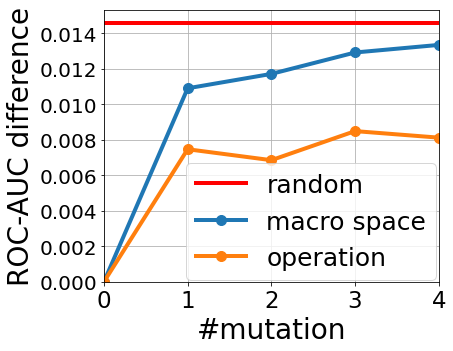

In [51]:
lines = []
dname = "proteins"
plt.figure(figsize = (6,5))
#plt.errorbar(range(5), stas[dname]['mean'], yerr=stas[dname]['std'])
plt.plot(range(5), [stas[dname]['tot'] for  i in range(5)], color ="red", label="random", linewidth=4)
plt.plot(range(5), stas[dname]['o'], marker = "o", markersize=10, label="macro space", linewidth=4)
plt.plot(range(5), stas[dname]['t'], marker = "o", markersize=10, label="operation", linewidth=4)
plt.xlabel("#mutation", size = 28)
plt.ylabel("ROC-AUC difference", size = 28)
plt.xticks(range(5),size = 23)
plt.yticks(size = 20)
plt.xlim(0, 4)
plt.ylim(0, None)
plt.grid()
# for cora citeseer photo
plt.legend(bbox_to_anchor=(1.03,-0.04), loc = "lower right", prop = {"size":25})
#plt.legend(bbox_to_anchor=(0.8,0.5), loc = "lower right", prop = {"size":25})
# for other datasets
#plt.legend(loc = "best", prop = {"size":20})
plt.savefig("image/ea0_{}.pdf".format(dname), bbox_inches='tight')
plt.show()

In [19]:
def permute_all(arch, is_proteins):
    fin = []
    for i in range(4):
        gnns = gnn_list_proteins if is_proteins else gnn_list
        for op in gnns:
            if op == arch.ops[i]:
                continue
            ops = arch.ops[:]
            lk = arch.link[:]
            ops[i] = op
            if ops[0] == 'skip' and ops[1] == 'skip' and ops[2] == 'skip' and ops[3] == 'skip':
                continue
            fin.append(Arch(lk, ops))
    for i in range(1, 4):
        for j in range(i + 1):
            if j == arch.link[i]:
                continue
            ops = arch.ops[:]
            lk = arch.link[:]
            lk[i] = j
            fin.append(Arch(lk, ops))
    return fin

def best_arch(bench):
    bestp = 0
    besth = None
    for h in hashs:
        if h in bench and bench[h]['perf'] > bestp:
            bestp, besth = bench[h]['perf'], h
    return besth
    arch = h2a[besth]
    return arch

def real_arch(a):
    b = regularize(a)
    b.move_skip_op()
    b.equalpart_sort()
    return b

# get greedy graph
def add_edge(h1, h2):
    head[h1] = {'to':h2, 'next':head.get(h1, None)}
     
ans = {}
for dname in dnames:
    head = {}
    bench = benchs[dname]
    for h in hashs:
        if h not in bench:
            continue
        arch = h2a[h]
        bestp = bench[h]['perf']
        besta = None
        plist = permute_all(arch, dname == 'proteins')
        for a in plist:
            b = real_arch(a)
            bh = b.hash_arch()
            if bench[bh]['perf'] > bestp:
                bestp, besta = bench[bh]['perf'], bh
        if besta:
            add_edge(besta, h)

    barch = best_arch(bench)
    q = [barch]
    v = {barch:True}
    while q:
        h = q[0]
        del q[0]
        edge = head.get(h, None)
        while edge:
            b = edge['to']
            if not v.get(b, False):
                q.append(b)
                v[b] = True
            edge = edge['next']
    print(dname)
    print(len(v) / len(bench))
    ans[dname] = len(v) / len(bench)


cora
0.014996565671983516
citeseer
0.005723880027474624
pubmed
0.016942684881324888
cs
0.08288178279783255
physics
0.02915362893993742
photo
0.023544226513012287
computers
0.013088605662825306
arxiv
0.007402884835533847
proteins
0.012370113805047007


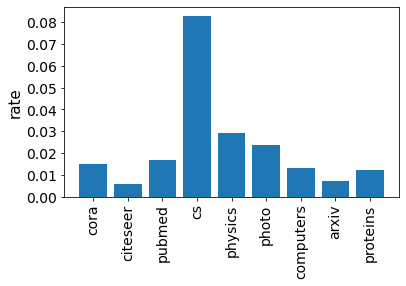

In [36]:
#ax = df.plot(kind = 'bar')
plt.figure(figsize = (6,3.5))
plt.bar(ans.keys(), ans.values(), width=0.8)
#plt.xlabel("dataset", size = 15)
plt.ylabel("rate", size = 15)
plt.xticks(size = 14, rotation=90)
plt.yticks(size = 14)
#plt.xlim(0, 9)
plt.savefig("image/ea1.pdf", bbox_inches='tight')
plt.show()

In [52]:
# analysis of RL
def get_eta2(bench, is_proteins):
    pair1 = []
    pair2 = []
    pair3 = []
    if not is_proteins:
        gnns = gnn_list
    else:
        gnns = gnn_list_proteins

    ops = [None for i in range(4)]
    lk = [None for i in range(4)]
    lk[0] = 0
    for g0 in gnns:
        ops[0] = g0
        arch1 = set()

        for g1 in gnns:
            ops[1] = g1
            for l1 in range(2):
                lk[1] = l1
                arch2 = set()

                for g2 in gnns:
                    ops[2] = g2
                    for l2 in range(3):
                        lk[2] = l2
                        arch3 = set()

                        for g3 in gnns:
                            if g0 == 'skip' and g1 == 'skip' and g2 == 'skip' and g3 == 'skip':
                                continue
                            ops[3] = g3
                            for l3 in range(4):
                                lk[3] = l3

                                a = Arch(lk, ops)
                                h = a.valid_hash()
                                arch1.add(h)
                                arch2.add(h)
                                arch3.add(h)
                        
                        perf3 = [bench[i]['perf'] for i in arch3]
                        len3 = len(arch3)
                        mean3 = sum(perf3) / len3
                        pair3.append((mean3, len3))
                
                perf2 = [bench[i]['perf'] for i in arch2]
                len2 = len(arch2)
                mean2 = sum(perf2) / len2
                pair2.append((mean2, len2))

        perf1 = [bench[i]['perf'] for i in arch1]
        len1 = len(arch1)
        mean1 = sum(perf1) / len1
        pair1.append((mean1, len1))

    perfs = [bench[i]['perf'] for i in bench]
    mean0 = np.mean(perfs)
    sst = np.var(perfs)
    
    def get_ssb(pair):
        tot = 0
        totn = 0
        for pr in pair:
            tot += pr[1] * (pr[0] - mean0) ** 2
            totn += pr[1]
        return tot / totn / sst

    fin = [0, get_ssb(pair1), get_ssb(pair2), get_ssb(pair3)]
    return fin
    #print(get_ssb(pair2))
    #print(get_ssb(pair3))
    
def get_eta2_reverse(bench, is_proteins):
    pair1 = []
    pair2 = []
    pair3 = []
    if not is_proteins:
        gnns = gnn_list
    else:
        gnns = gnn_list_proteins

    ops = [None for i in range(4)]
    lk = [None for i in range(4)]
    lk[0] = 0
    for g0 in gnns:
        ops[3] = g0
        for l3 in range(4):
            lk[3] = l3
            arch1 = set()

            for g1 in gnns:
                ops[2] = g1
                for l1 in range(3):
                    lk[2] = l1
                    arch2 = set()

                    for g2 in gnns:
                        ops[1] = g2
                        for l2 in range(2):
                            lk[1] = l2
                            arch3 = set()

                            for g3 in gnns:
                                if g0 == 'skip' and g1 == 'skip' and g2 == 'skip' and g3 == 'skip':
                                    continue
                                ops[0] = g3

                                a = Arch(lk, ops)
                                h = a.valid_hash()
                                arch1.add(h)
                                arch2.add(h)
                                arch3.add(h)
                            
                            perf3 = [bench[i]['perf'] for i in arch3]
                            len3 = len(arch3)
                            mean3 = sum(perf3) / len3
                            pair3.append((mean3, len3))
                        
                    perf2 = [bench[i]['perf'] for i in arch2]
                    len2 = len(arch2)
                    mean2 = sum(perf2) / len2
                    pair2.append((mean2, len2))

            perf1 = [bench[i]['perf'] for i in arch1]
            len1 = len(arch1)
            mean1 = sum(perf1) / len1
            pair1.append((mean1, len1))

    perfs = [bench[i]['perf'] for i in bench]
    mean0 = np.mean(perfs)
    sst = np.var(perfs)
    
    def get_ssb(pair):
        tot = 0
        totn = 0
        for pr in pair:
            tot += pr[1] * (pr[0] - mean0) ** 2
            totn += pr[1]
        return tot / totn / sst

    fin = [0, get_ssb(pair1), get_ssb(pair2), get_ssb(pair3)]
    return fin

stas = {}
for dname in dnames:
    print(dname)
    stas[dname] = {}
    fin = get_eta2(benchs[dname], dname=="proteins")
    stas[dname]['c'] = fin
    fin = get_eta2_reverse(benchs[dname], dname=="proteins")
    stas[dname]['r'] = fin

cora
citeseer
pubmed
cs
physics
photo
computers
arxiv
proteins


[0, 0.04104541090355243, 0.1182618411409901, 0.35148295551145387]


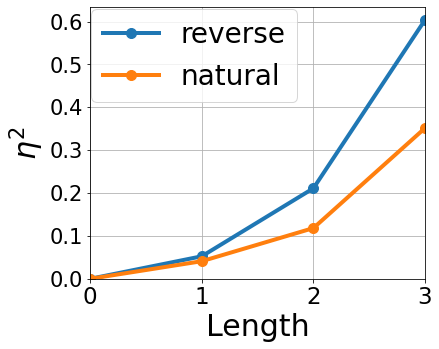

In [79]:
lines = []
dname = "proteins"
plt.figure(figsize = (6,5))
print(stas[dname]['c'])
#plt.errorbar(range(5), stas[dname]['mean'], yerr=stas[dname]['std'])
plt.plot(range(4), stas[dname]['r'], marker="o", markersize=10, label="reverse", linewidth=4)
plt.plot(range(4), stas[dname]['c'], marker="o", markersize=10, label="natural", linewidth=4)
#plt.plot(range(4), [stas[dname]['tot'] for  i in range(5)], color ="red", linewidth=4)
plt.xlabel("Length", size = 30)
plt.ylabel("$\eta^2$", size = 30)
plt.xticks(range(4),size = 23)
plt.yticks(np.arange(0,0.7,0.1),size = 21)
plt.xlim(0, 3)
plt.ylim(0, None)
plt.grid()
#plt.legend(loc = "best", prop = {"size":30})
#plt.legend(bbox_to_anchor=(1.03,-0.04), loc = "lower right", prop = {"size":25})
plt.legend(bbox_to_anchor=(0.66,0.6), loc = "lower right", prop = {"size":28})
plt.savefig("image/rl_{}.pdf".format(dname), bbox_inches='tight')
plt.show()

In [2]:
# topo stat
import pandas as pd
topo_count = [0 for i in link_list]
topo_count_proteins = [0 for i in link_list]
data_topo_count = {}
h2a = {}
def topo2id(link):
    for i, topo in enumerate(link_list):
        if topo == link:
            return i

for arch in archs:
    h = arch.hash_arch()
    h2a[h] = arch
    i = topo2id(arch.link)
    topo_count[i] = topo_count[i] + 1
    if h in benchs['proteins']:
        topo_count_proteins[i] = topo_count_proteins[i] + 1

for dname in dnames:
    tarchs = toparchs[dname]
    tcount = [0 for i in link_list]
    for h in tarchs:
        arch = h2a[h]
        i = topo2id(arch.link)
        tcount[i] = tcount[i] + 1
    for i in range(len(link_list)):
        tcount[i] = tcount[i] / topo_count[i]
    data_topo_count[dname] = tcount
 
df = pd.DataFrame(data_topo_count)
df.index = ["A","B","C","D","E","F","G","H","I"]
dft = df.T

#print(topo_count)

In [3]:
# gnn stat
from net import gnn_list
data_gnn_count = {}
def gnn2id(gname):
    for i, gnn in enumerate(gnn_list):
        if gnn == gname:
            return i

for dname in dnames:
    tot = 0
    tarchs = toparchs[dname]
    tcount = [0 for i in gnn_list]
    for h in tarchs:
        arch = h2a[h]
        for lk, gconv in zip(arch.link, arch.ops):
            if lk:
                continue
            i = gnn2id(gconv)
            tot += 1
            tcount[i] = tcount[i] + 1
    for i in range(len(gnn_list)):
        tcount[i] = tcount[i] / tot
    data_gnn_count[dname] = tcount
data_gnn_count['proteins'][4] = data_gnn_count['proteins'][3]
data_gnn_count['proteins'][3] = 0
 
gnn_name = ['GAT', 'GCN', 'GIN', 'Cheb', 'SAGE', 'ARMA', 'k-GNN', 'FC', 'Identity']
df = pd.DataFrame(data_gnn_count)
df.index = gnn_name
dft = df.T

In [85]:
subgraph_count = {}
tcount = {}
for dname in dnames:
    tarchs = toparchs[dname]
    for h in tarchs:
        arch = h2a[h]
        for i in range(len(arch.link)):
            for j in range(i + 1, len(arch.link)):
                # brother
                if arch.link[i] == arch.link[j]:
                    subgraph = arch.ops[i] + "0" + arch.ops[j]
                elif i + 1 == arch.link[j]:
                    subgraph = arch.ops[i] + "1" + arch.ops[j]
                else:
                    subgraph = None

                if subgraph:
                    tcount[subgraph] = tcount.get(subgraph, 0) + 1
    subgraph_count[dname] = tcount

df = pd.DataFrame(subgraph_count)
df.fillna(0, inplace=True)
df = df.sort_values(by="cora", ascending=False)
dft = df[:20]
dft

,cora,citeseer,pubmed,cs,physics,photo,computers,arxiv
gat1gat,1022,1022,1022,1022,1022,1022,1022,1022
gat1gcn,918,918,918,918,918,918,918,918
gcn1gcn,906,906,906,906,906,906,906,906
gat1sage,879,879,879,879,879,879,879,879
gcn1cheb,799,799,799,799,799,799,799,799
gcn0gcn,770,770,770,770,770,770,770,770
gcn1arma,769,769,769,769,769,769,769,769
gat0gcn,747,747,747,747,747,747,747,747
cheb1gcn,738,738,738,738,738,738,738,738
gcn1sage,708,708,708,708,708,708,708,708


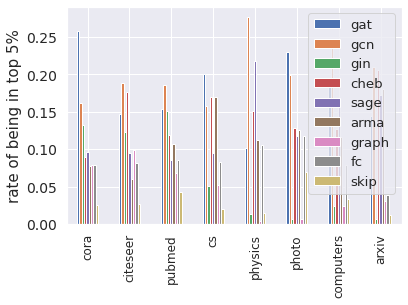

In [49]:
ax = dft.plot(kind = 'bar')
#plt.xlabel("dataset", size = 15)
plt.ylabel("rate of being in top 5%", size = 15)
plt.xticks(size = 12)
plt.yticks(size = 14)
#plt.xlim(0, 9)
plt.savefig("image/topo.pdf", bbox_inches='tight')
plt.show()

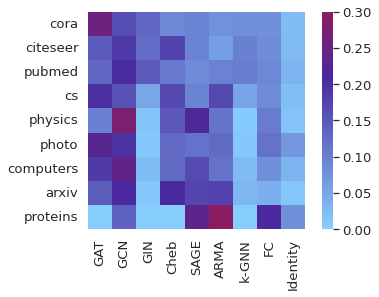

In [15]:
import seaborn

cor = dft
#画出热力图
seaborn.set(font_scale=1.2)
#heat_color = LinearSegmentedColormap.from_list('', [(0.0, '#87ceff'), (0.6, '#49299d'), (1.0, '#8b1c62')])
heat_color = LinearSegmentedColormap.from_list('', [(0.0, '#87ceff'), (0.7, '#49299d'), (1.0, '#8b1c62')])
fig = seaborn.heatmap(cor,vmin=0,vmax=0.30,cmap=heat_color,square=True)
#plt.imshow(cor,cmap=heat_color)

#必须要配合matplotlib才可使用
#plt.title("heatmap")``
#plt.xlabel("x_ticks")
#plt.ylabel("y_ticks")
#plt.xticks(size = 15)
#plt.colorbar()
plt.show()
fig = fig.get_figure()
fig.savefig("image/heat_gnn_0.pdf", bbox_inches="tight")
#plt.savefig("image/cor3.pdf", bbox_inches='tight')

In [2]:
# point image: perf, latency and parameters
dname = 'citeseer'
bench = benchs[dname]
print(len(bench))
#lats = list(map(lambda x:bench[x]['latency'], hashs))
#perfs = list(map(lambda x:bench[x]['perf'], hashs))
prt_lats = []
prt_perfs = []
prt_paras = []
nor_lats = []
nor_perfs = []
nor_paras = []
cnt = 0
for h in hashs:
    if h not in bench:
        continue
    cnt += 1
    flag = True
    perf = bench[h]['perf']
    lat = bench[h]['latency']
    for i in hashs:
        if i not in bench:
            continue
        if bench[i]['perf'] >= perf and bench[i]['latency'] < lat:
            flag = False
            break
    if flag:
        prt_lats.append(lat)
        prt_perfs.append(perf)
        prt_paras.append(bench[h]['para'])
    else:
        nor_lats.append(lat)
        nor_perfs.append(perf)
        nor_paras.append(bench[h]['para'])

prt_lats = list(map(lambda x: x*1000, prt_lats))
nor_lats = list(map(lambda x: x*1000, nor_lats))
print(cnt)

26206
26206


13
26193
0.4092852274576823


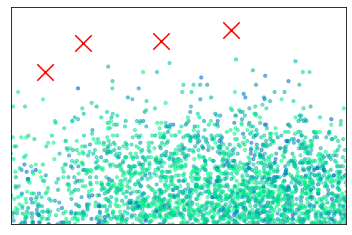

In [6]:
import numpy as np
print(len(prt_lats))
print(len(nor_lats))
print(min(prt_lats))
#print(prt_lats)

def get_colors(paras):
    pmin = min(paras)
    pmax = max(paras)
    cmin = (0.7, 0, 0.7)
    cmax = (0, 0.9, 0.7)
    cols = []
    for i in paras:
        def one_col(a):
            amin, amax = a
            fin = ((i - pmin) * amax + (pmax - i) * amin) / (pmax - pmin)
            return fin
        col = tuple(map(one_col, zip(cmin, cmax)))
        cols.append(col)
    return cols

#plt.scatter(lats, perfs, s = 3, alpha = 1)
plt.scatter(nor_lats, nor_perfs, c = nor_paras, cmap = "winter_r", s = 10, alpha = 0.5)
#plt.scatter(nor_lats, nor_perfs, c = get_colors(nor_paras), s = 3, alpha = 0.1)
#plt.colorbar(aspect = 9, fraction=0.05, pad=0.05, format=  '%.1f', ticks = np.arange(0,0.5,0.1))

#cb = plt.colorbar(format=  '%.2f')
#cb.set_label('#parameters(M)', fontsize=15)
#cb.set_ticks(np.arange(0.9, 1.05, 0.05), fontsize=14)
plt.scatter(prt_lats, prt_perfs, c = 'red', s = 270, alpha = 1, marker = 'x')
#plt.xlabel("latency(ms)", size = 15)
#plt.ylabel("accuracy", size = 15)
#plt.xticks(size = 14)
#plt.yticks(np.arange(0.4, 0.8, 0.1), size = 14)

plt.xticks([])
plt.yticks([])
#plt.grid()

plt.xlim(2, 5)
plt.ylim(0.68, 0.72)
plt.savefig("image/lat_{}.pdf".format(dname), bbox_inches='tight')
plt.show()

In [4]:
# get correlation
df = pd.DataFrame(ranks)
#df.corr()
df.corr('kendall')

,cora,citeseer,pubmed,cs,physics,photo,computers,arxiv
cora,1.000000,0.558209,0.434728,0.274500,0.223156,0.200352,0.145424,0.148893
citeseer,0.558209,1.000000,0.430519,0.311035,0.240250,0.212931,0.119100,0.102920
pubmed,0.434728,0.430519,1.000000,0.247472,0.254916,0.264810,0.219482,0.171019
cs,0.274500,0.311035,0.247472,1.000000,0.290674,0.342509,0.122148,0.050136
physics,0.223156,0.240250,0.254916,0.290674,1.000000,0.357823,0.233094,0.280611
photo,0.200352,0.212931,0.264810,0.342509,0.357823,1.000000,0.424888,0.318033
computers,0.145424,0.119100,0.219482,0.122148,0.233094,0.424888,1.000000,0.399544
arxiv,0.148893,0.102920,0.171019,0.050136,0.280611,0.318033,0.399544,1.000000


In [9]:
best_corr = []
for d1 in dnames[:-1]:
    best_corr.append([])
    best_h = sorted_hashs[d1][0]
    for d2 in dnames[:-1]:
        shs = sorted_hashs[d2]
        for i, h in enumerate(shs):
            if h == best_h:
                break
        best_corr[-1].append(1 - i / 26206)
tdf = pd.DataFrame(best_corr)
tdf.columns = dnames[:-1]
tdf.index = dnames[:-1]
tdf

,cora,citeseer,pubmed,cs,physics,photo,computers,arxiv
cora,1.000000,0.730558,0.218461,0.416508,0.758529,0.611387,0.232428,0.768755
citeseer,0.999847,1.000000,0.938068,0.698809,0.683660,0.357781,0.386667,0.383385
pubmed,0.692628,0.955201,1.000000,0.997405,0.574907,0.412501,0.232351,0.471686
cs,0.637411,0.960009,0.942036,1.000000,0.714264,0.222926,0.574449,0.662673
physics,0.089102,0.063192,0.439251,0.823247,1.000000,0.604633,0.507556,0.950279
photo,0.560597,0.450202,0.670343,0.950240,0.939365,1.000000,0.490498,0.754178
computers,0.915210,0.860681,0.918187,0.882622,0.622148,0.778410,1.000000,0.899489
arxiv,0.054186,0.038045,0.035030,0.152560,0.971190,0.738304,0.860337,1.000000


In [11]:
top_inter = []
for d1 in dnames:
    top_inter.append([])
    for d2 in dnames:
        inter = toparchs[d1].intersection(toparchs[d2])
        top_inter[-1].append(len(inter) / 1310)
tdf = pd.DataFrame(top_inter)
tdf.columns = dnames
tdf.index = dnames
tdf

,cora,citeseer,pubmed,cs,physics,photo,computers,arxiv
cora,1.000000,0.167939,0.209924,0.097710,0.104580,0.116031,0.100763,0.037405
citeseer,0.167939,1.000000,0.143511,0.118321,0.077099,0.077099,0.058015,0.011450
pubmed,0.209924,0.143511,1.000000,0.100763,0.049618,0.056489,0.067939,0.022901
cs,0.097710,0.118321,0.100763,1.000000,0.064885,0.091603,0.067939,0.019847
physics,0.104580,0.077099,0.049618,0.064885,1.000000,0.141985,0.216794,0.194656
photo,0.116031,0.077099,0.056489,0.091603,0.141985,1.000000,0.154198,0.071756
computers,0.100763,0.058015,0.067939,0.067939,0.216794,0.154198,1.000000,0.161069
arxiv,0.037405,0.011450,0.022901,0.019847,0.194656,0.071756,0.161069,1.000000


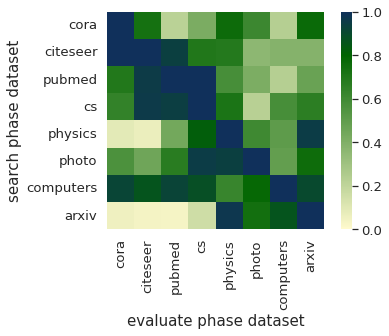

In [14]:
import seaborn

cor = tdf
#画出热力图
seaborn.set(font_scale=1.2)
heat_color = LinearSegmentedColormap.from_list('', [(0.0, '#fffacd'), (0.8, 'darkgreen'), (1.0, '#10305b')])
fig = seaborn.heatmap(cor,vmin=0,vmax=1.0,cmap=heat_color,square=True)
#plt.imshow(cor,cmap=heat_color)

#必须要配合matplotlib才可使用
#plt.title("heatmap")
#plt.xlabel("x_ticks")
#plt.ylabel("y_ticks")
#plt.xticks(size = 15)
#plt.colorbar()
plt.ylabel("search phase dataset", size = 15)
plt.xlabel("evaluate phase dataset", size = 15)
plt.show()
fig = fig.get_figure()
fig.savefig("image/heat4.pdf", bbox_inches="tight")
#plt.savefig("image/cor3.pdf", bbox_inches='tight')

In [14]:
test_data = {
    "col_a": [1, 2, 3],
    "col_b": [1, 2, 1]
}
test_df = pd.DataFrame(test_data)
a = test_df.corr()
type(a)

pandas.core.frame.DataFrame